## <center>Stock Price Prediction: Comparison between ARIMA Model and LSTM</center>
## <center>Xizhu Lin</center>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm

In [4]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

# The Boeing Company (BA) & Zoom Video Communications, Inc. (ZM)

## Import Data

In [5]:
start_date = '2020-01-01'
end_date = '2023-05-12'

ba = yf.download("BA", start_date , end_date)['Close']
zm = yf.download("ZM", start_date , end_date)['Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
ba = pd.DataFrame(ba)
# check if there is null values in BA Close price
ba[ba.isna().any(axis=1)]

,Close
Date,


In [7]:
# First-order differencing
ba_diff = ba.diff().dropna()
# Log price of BA
ba_lgp = np.log(ba)
# Log Returns of BA
ba_rtn = np.log(ba).diff().dropna()

In [8]:
zm = pd.DataFrame(zm)
# check if there is null values in ZM Close price 
zm[zm.isna().any(axis=1)]

,Close
Date,


In [9]:
# First-order differencing
zm_diff = zm.diff().dropna()
# Log price of ZM
zm_lgp = np.log(zm)
# Log Returns of ZM
zm_rtn = np.log(zm).diff().dropna()

## EDA

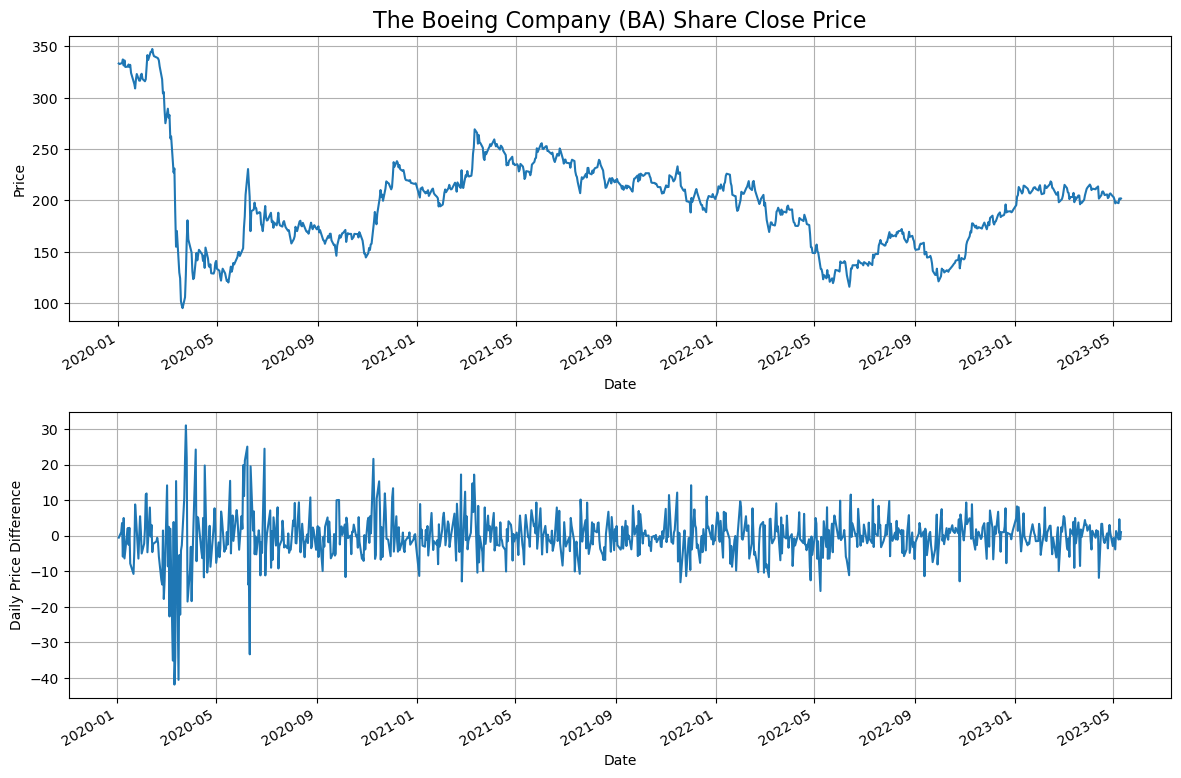

In [10]:
plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
ba['Close'].plot()
plt.grid()
plt.ylabel("Price")
plt.title("The Boeing Company (BA) Share Close Price", fontsize = 16)
plt.subplot(2, 1, 2)
ba_diff['Close'].plot()
plt.grid()
plt.tight_layout(pad=1.5)
plt.ylabel("Daily Price Difference")

plt.savefig("images/Boeing_Company_(BA)_stationary_1")

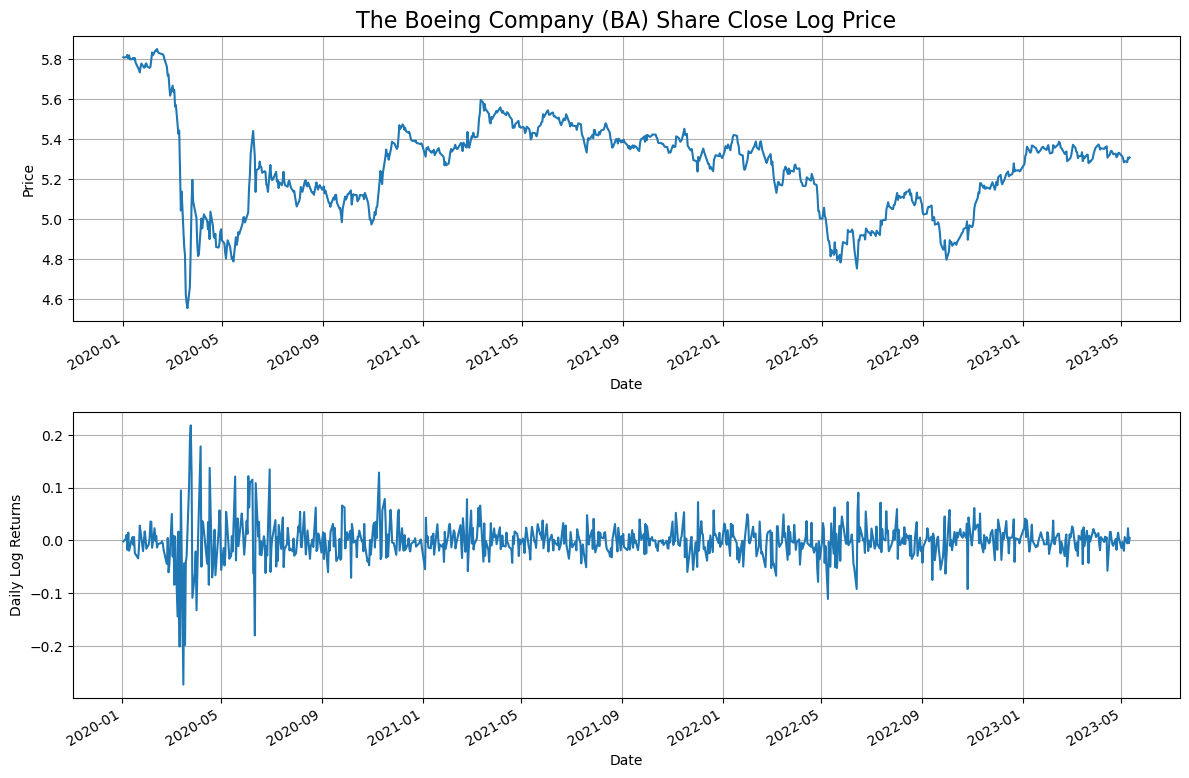

In [11]:
plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
ba_lgp['Close'].plot()
plt.grid()
plt.ylabel("Price")
plt.title("The Boeing Company (BA) Share Close Log Price", fontsize = 16)
plt.subplot(2, 1, 2)
ba_rtn['Close'].plot()
plt.grid()
plt.tight_layout(pad=1.5)
plt.ylabel("Daily Log Returns")

plt.savefig("images/Boeing_Company_(BA)_stationary_2")

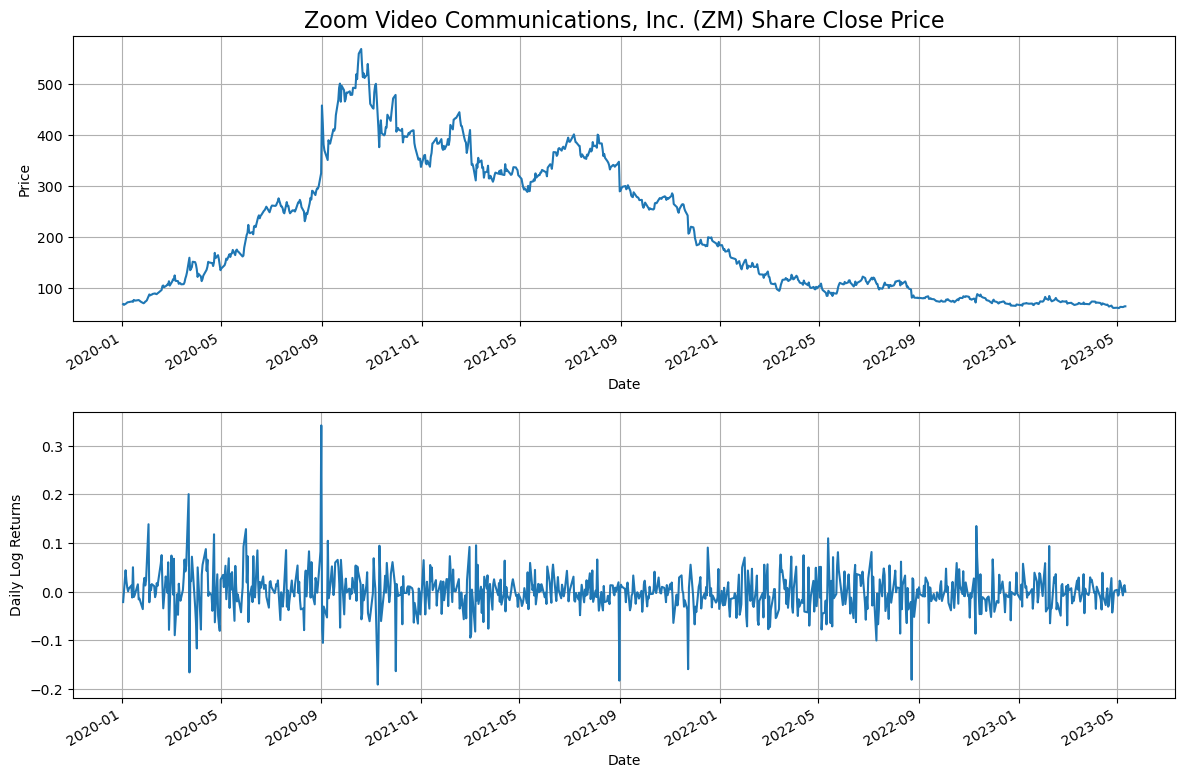

In [12]:
plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
zm['Close'].plot()
plt.grid()
plt.ylabel("Price")
plt.title("Zoom Video Communications, Inc. (ZM) Share Close Price", fontsize = 16)
plt.subplot(2, 1, 2)
zm_rtn['Close'].plot()
plt.grid()
plt.tight_layout(pad=1.5)
plt.ylabel("Daily Log Returns")

plt.savefig("images/Zoom_(ZM)_stationary_1")

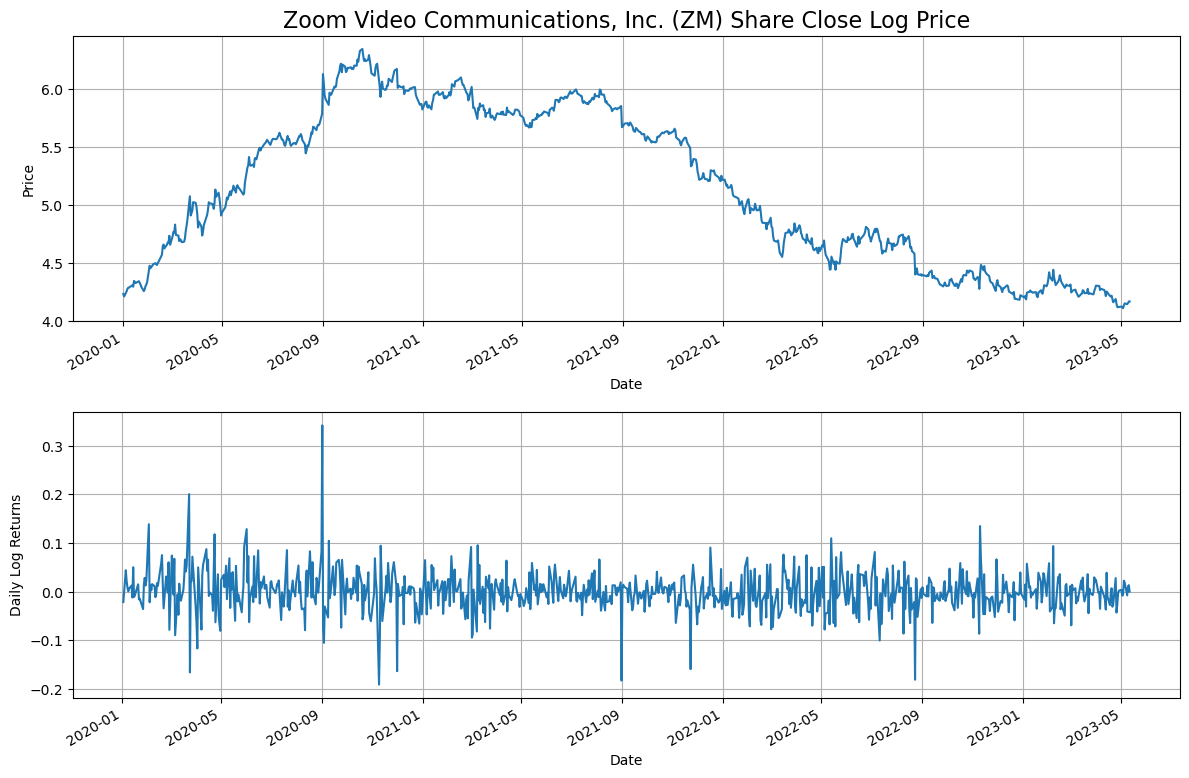

In [13]:
plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
zm_lgp['Close'].plot()
plt.grid()
plt.ylabel("Price")
plt.title("Zoom Video Communications, Inc. (ZM) Share Close Log Price", fontsize = 16)
plt.subplot(2, 1, 2)
zm_rtn['Close'].plot()
plt.grid()
plt.tight_layout(pad=1.5)
plt.ylabel("Daily Log Returns")

plt.savefig("images/Zoom_(ZM)_stationary_2")

In [14]:
df = pd.merge(ba, zm, left_index=True, right_index=True)
df = df.rename(columns={'Close_x': 'Close_BA', 'Close_y': 'Close_ZM'})

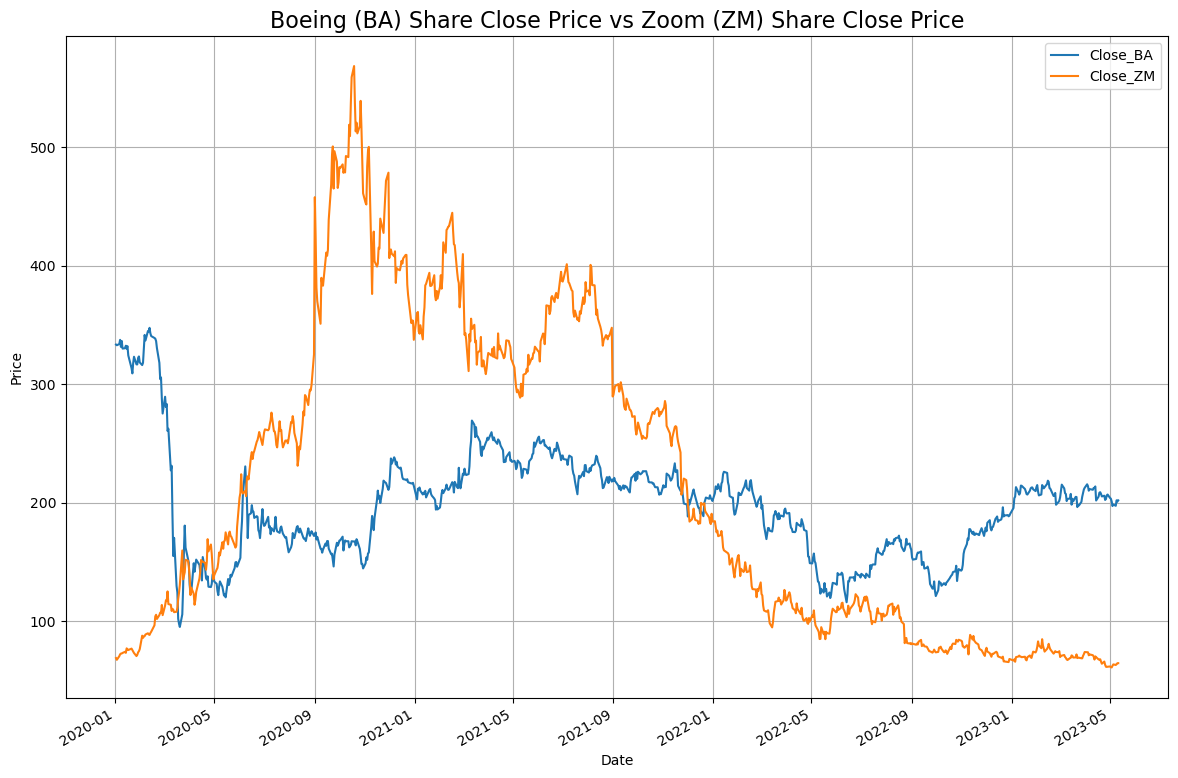

In [15]:
plt.figure(figsize=(12,8))

df['Close_BA'].plot()
df['Close_ZM'].plot()
plt.grid()
plt.ylabel("Price")
plt.title("Boeing (BA) Share Close Price vs Zoom (ZM) Share Close Price", fontsize = 16)
plt.legend(bbox_to_anchor = (1,1))
plt.tight_layout(pad=1.5)

plt.savefig("images/Boeing_and_Zoom")

## Price Prediction Model: ARIMA Model and LSTM

## ARIMA Model

### Boeing (BA)

In [16]:
# Get the number of rows to train the model on
training_ba_len = int(np.ceil(len(ba) * .8 ))
# Create the scaled training data set
train_ba = ba[0:int(training_ba_len)]
# First-order differencing
train_ba_diff = train_ba.diff().dropna()
# Log price 
train_ba_lgp = np.log(train_ba)
# Log Returns 
train_ba_rtn = np.log(train_ba).diff().dropna()

### 1. Find d in (p, d, q) for ARIMA model and (ADF) test

In [17]:
# BA Pirce d=0
result = adfuller(train_ba)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.100203
p-value: 0.026538
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [18]:
# BA Pirce d=1
result = adfuller(train_ba_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.435893
p-value: 0.000000
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [19]:
# BA Log Pirce d=0
result = adfuller(train_ba_lgp)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.045616
p-value: 0.030848
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [20]:
# BA Log Pirce d=1
result = adfuller(train_ba_rtn)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.264118
p-value: 0.000000
	1%: -3.440
	5%: -2.866
	10%: -2.569


### Choose BA Log Pirce d=1, use train_ba_lgp (log price of BA) d=1 in ARIMA Model

### 2. Find p and q in (p, d, q) for ARIMA model
### Method 1, Step 1: ACF plot and PACF plot

In [21]:
def plot_diagnosticsTight2(data, rtn, title1 = 'APPLE'):

    fig, axes = plt.subplots(1,2,figsize=(15,5))
    axes[0].set_ylabel('ACF', fontsize=15)
    axes[0].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(data,lags=25,zero=True, ax = axes[0], title= 'ACF '+ title1, use_vlines = True)
    axes[1].set_ylabel('ACF', fontsize=15)
    axes[1].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(rtn,lags=25,zero=True, ax = axes[1], title= 'ACF Log Returns '+ title1, use_vlines = True)
    plt.tight_layout()
    plt.savefig("ACF2.png", dpi = 300)

In [22]:
def plot_ACF_PACF(data, lag_num, company_name):
    fig, axes = plt.subplots(1,2,figsize=(15,5))

    fig = plot_acf(data.values, lags = lag_num, zero=False, ax = axes[0],
                   title= 'ACF of ' + company_name + ' log prices')
    
    fig = plot_pacf(data.values, lags = lag_num, zero=False, ax = axes[1],
                   title= 'PACF of ' + company_name + ' log prices')

    # plt.show()
    plt.savefig("images/ACF PACF" + company_name, dpi = 300)

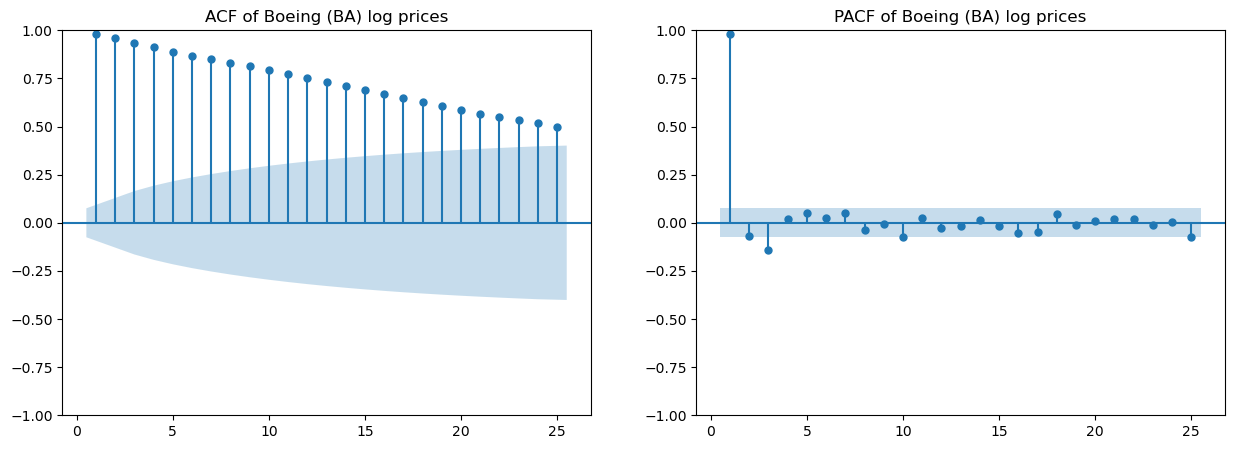

In [23]:
plot_ACF_PACF(train_ba_lgp, 25, 'Boeing (BA)')

#plt.savefig("images/Boeing_Company_(BA)_ACF_PACF")

### p=2, q=0

In [24]:
p, d, q = 2, 1, 0
ar_model_ba = ARIMA(train_ba_lgp['Close'], order=(p, d, q))
ar_model_ba = ar_model_ba.fit()
ar_model_ba.summary()

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  677
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1236.277
Date:                Fri, 15 Dec 2023   AIC                          -2466.554
Time:                        20:01:30   BIC                          -2453.005
Sample:                             0   HQIC                         -2461.308
                                - 677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0636      0.018      3.577      0.000       0.029       0.098
ar.L2          0.1626      0.017      9.523      0.000       0.129       0.196
sigma2         0.0015   4.04e-05     37.406      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1515.64
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 2. Find p and q in (p, d, q) for ARIMA model 
### Method 1, Step 2: p-value test

In [25]:
# Set the significance level (alpha)
alpha = 0.05

p_values = ar_model_ba.pvalues

significant_predictors = p_values[p_values <= alpha]

print("Significant Predictors:")
print(significant_predictors)

Significant Predictors:
ar.L1      3.471556e-04
ar.L2      1.684478e-21
sigma2    3.083713e-306
dtype: float64


### 2. Find p and q in (p, d, q) for ARIMA model 
### Method 2: grid search for min AIC and min BIC

In [26]:
def searchARIMA(data, d, max_p, max_q):
    results = []

    aic = np.zeros((max_p, max_q))
    bic = np.zeros((max_p, max_q))

    for i in range(max_p):
        for j in range(max_q):
            model = ARIMA(data, order=(i, d, j))
            model = ARIMA(data, order=(i, d, j))
            res = model.fit()
            aic[i, j] = res.aic
            bic[i, j] = res.bic

            result_dict = {
                'p': i,
                'q': j,
                'aic': aic[i, j],
                'bic': bic[i, j]
            }
            results.append(result_dict)
            # print('p:', i, ' q:', j, ' aic:', aic[i, j], ' bic:', bic[i, j])

    result_df = pd.DataFrame(results)
    return result_df

In [27]:
result_df = searchARIMA(train_ba_lgp.values, d = 1, max_p = 10, max_q = 10)
result_df

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarni

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarni

,p,q,aic,bic
0,0,0,-2448.614890,-2444.098697
1,0,1,-2449.534203,-2440.501817
2,0,2,-2469.495778,-2455.947199
3,0,3,-2467.608602,-2449.543830
4,0,4,-2465.744453,-2443.163488
...,...,...,...,...
95,9,5,-2460.106052,-2392.363156
96,9,6,-2459.101628,-2386.842539
97,9,7,-2459.114381,-2382.339099
98,9,8,-2457.036662,-2375.745187


In [28]:
min_aic_bic_row = result_df[(result_df['aic'] == result_df['aic'].min()) |
                            (result_df['bic'] == result_df['bic'].min())]
min_aic_bic_row

,p,q,aic,bic
2,0,2,-2469.495778,-2455.947199
46,4,6,-2470.604216,-2420.926092


In [29]:
pm.arima.auto_arima(train_ba_lgp)

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### In general, choose p=2, q=0

In [30]:
p, d, q = 2, 1, 0
ar_model_ba = ARIMA(train_ba_lgp['Close'], order=(p, d, q))
ar_model_ba = ar_model_ba.fit()
ar_model_ba.summary()

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  677
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1236.277
Date:                Fri, 15 Dec 2023   AIC                          -2466.554
Time:                        20:04:53   BIC                          -2453.005
Sample:                             0   HQIC                         -2461.308
                                - 677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0636      0.018      3.577      0.000       0.029       0.098
ar.L2          0.1626      0.017      9.523      0.000       0.129       0.196
sigma2         0.0015   4.04e-05     37.406      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1515.64
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Set the significance level (alpha)
alpha = 0.05

p_values = ar_model_ba.pvalues

significant_predictors = p_values[p_values <= alpha]

print("Significant Predictors:")
print(significant_predictors)

Significant Predictors:
ar.L1      3.471556e-04
ar.L2      1.684478e-21
sigma2    3.083713e-306
dtype: float64


In [32]:
predicted_original_train_ba = ar_model_ba.predict(start=train_ba_lgp.index[0], 
                                                  end=train_ba_lgp.index[-1], 
                                                  dynamic=False)
predicted_original_train_ba = np.exp(predicted_original_train_ba)
#predicted_original_ba = np.array(predicted_original_ba)

In [33]:
predicted_original_train_ba = pd.DataFrame(predicted_original_train_ba)

train_val_ba = ba[:int(training_ba_len)]
train_val_ba = pd.merge(train_val_ba, predicted_original_train_ba, 
                        left_index=True, right_index=True)
train_val_ba = train_val_ba.rename(columns={'predicted_mean': 'Prediction'})
train_val_ba

,Close,Prediction
Date,,
2020-01-02,333.320007,1.000000
2020-01-03,332.760010,333.320008
2020-01-06,333.739990,332.717537
2020-01-07,337.279999,333.711147
2020-01-08,331.369995,337.667707
...,...,...
2022-09-01,153.660004,159.616873
2022-09-02,151.820007,152.947757
2022-09-06,152.389999,150.671611


In [34]:
train_mse = mean_squared_error(train_val_ba['Close'], train_val_ba['Prediction'])
train_rmse = np.sqrt(train_mse)
print("The MSE of the Trainning set is", train_mse)
print("The RMSE of the Trainning set is", train_rmse)

The MSE of the Trainning set is 210.71958656497665
The RMSE of the Trainning set is 14.516183608820077


In [35]:
# Create the scaled training data set
test_ba = ba[int(training_ba_len):]
# Log price
test_ba_lgp = np.log(test_ba)

forecast_ba = ar_model_ba.get_forecast(steps=len(test_ba_lgp))

predicted_values_ba = forecast_ba.predicted_mean
predicted_original_ba = np.exp(predicted_values_ba)
predicted_original_ba = np.array(predicted_original_ba)

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [36]:
predicted_original_ba = pd.DataFrame(index=test_ba_lgp.index, columns=['Prediction'], 
                                     data=predicted_original_ba)

test_ba = pd.merge(test_ba, predicted_original_ba, 
                   left_index=True, right_index=True)
test_ba

,Close,Prediction
Date,,
2022-09-09,157.520004,158.501649
2022-09-12,158.720001,158.849633
2022-09-13,147.309998,158.988054
2022-09-14,149.259995,159.053558
2022-09-15,149.779999,159.080248
...,...,...
2023-05-05,198.339996,159.101817
2023-05-08,197.259995,159.101817
2023-05-09,201.880005,159.101817


In [37]:
test_mse = mean_squared_error(test_ba['Close'], test_ba['Prediction'])
test_rmse = np.sqrt(test_mse)
print("The MSE of the Test set is", test_mse)
print("The RMSE of the Test set is", test_rmse)

The MSE of the Test set is 1475.7237845602306
The RMSE of the Test set is 38.41515045604053


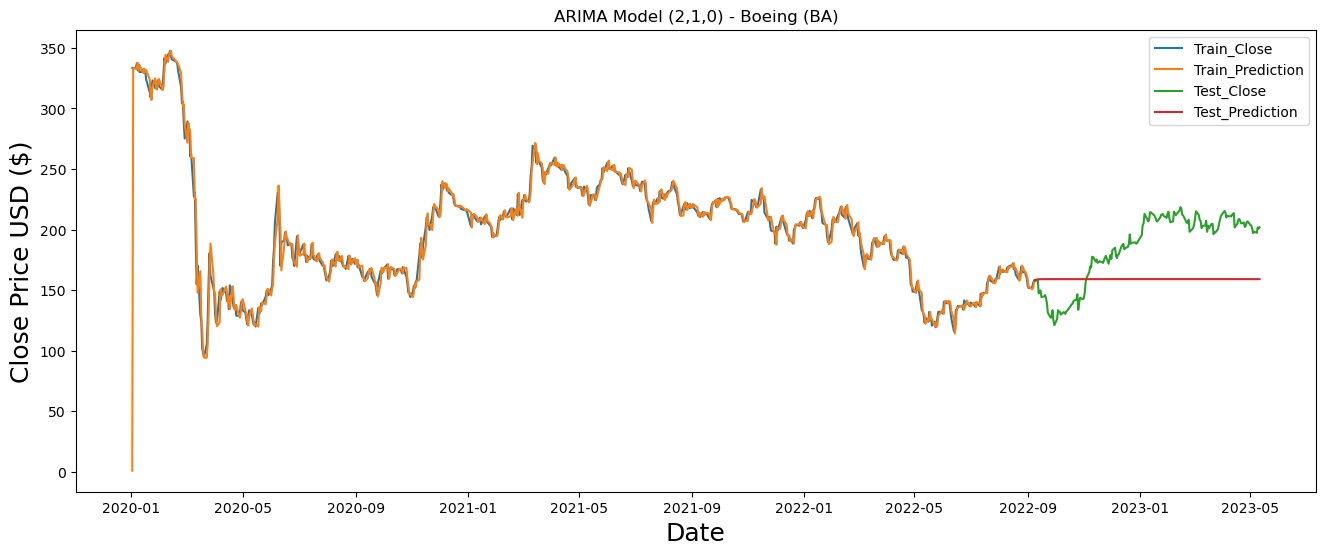

In [38]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('ARIMA Model (2,1,0) - Boeing (BA)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_val_ba[['Close', 'Prediction']])
plt.plot(test_ba[['Close', 'Prediction']])
plt.legend(['Train_Close', 'Train_Prediction','Test_Close', 'Test_Prediction'], loc='upper right')
#plt.show()
plt.savefig("images/Boeing_Company_(BA)_ARIMA_1")

In [39]:
p, d, q = 2, 0, 0
ar_model_ba = ARIMA(train_ba_lgp['Close'], order=(p, d, q))
ar_model_ba = ar_model_ba.fit()
ar_model_ba.summary()

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  677
Model:                 ARIMA(2, 0, 0)   Log Likelihood                1229.167
Date:                Fri, 15 Dec 2023   AIC                          -2450.334
Time:                        20:04:54   BIC                          -2432.263
Sample:                             0   HQIC                         -2443.338
                                - 677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3002      0.089     59.265      0.000       5.125       5.476
ar.L1          1.0705      0.019     55.603      0.000       1.033       1.108
ar.L2         -0.0832      0.018     -4.549      0.000      -0.119      -0.047
sigma2         0.0015   3.61e-05     42.695      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):              2340.08
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
# Set the significance level (alpha)
alpha = 0.05

p_values = ar_model_ba.pvalues

significant_predictors = p_values[p_values <= alpha]

print("Significant Predictors:")
print(significant_predictors)

Significant Predictors:
const     0.000000
ar.L1     0.000000
ar.L2     0.000005
sigma2    0.000000
dtype: float64


In [41]:
predicted_original_train_ba = ar_model_ba.predict(start=train_ba_lgp.index[0], 
                                                  end=train_ba_lgp.index[-1], 
                                                  dynamic=False)
predicted_original_train_ba = np.exp(predicted_original_train_ba)
#predicted_original_ba = np.array(predicted_original_ba)
predicted_original_train_ba = pd.DataFrame(predicted_original_train_ba)

train_val_ba = ba[:int(training_ba_len)]
train_val_ba = pd.merge(train_val_ba, predicted_original_train_ba, 
                        left_index=True, right_index=True)
train_val_ba = train_val_ba.rename(columns={'predicted_mean': 'Prediction'})
train_val_ba

,Close,Prediction
Date,,
2020-01-02,333.320007,200.386139
2020-01-03,332.760010,331.342606
2020-01-06,333.739990,330.583051
2020-01-07,337.279999,331.671768
2020-01-08,331.369995,335.357282
...,...,...
2022-09-01,153.660004,160.541874
2022-09-02,151.820007,153.639991
2022-09-06,152.389999,152.202058


In [42]:
train_mse = mean_squared_error(train_val_ba['Close'], train_val_ba['Prediction'])
train_rmse = np.sqrt(train_mse)
print("The MSE of the Trainning set is", train_mse)
print("The RMSE of the Trainning set is", train_rmse)

The MSE of the Trainning set is 74.27961633410533
The RMSE of the Trainning set is 8.618562312480273


In [43]:
# Create the scaled training data set
test_ba = ba[int(training_ba_len):]
# Log price
test_ba_lgp = np.log(test_ba)

forecast_ba = ar_model_ba.get_forecast(steps=len(test_ba_lgp))

predicted_values_ba = forecast_ba.predicted_mean
predicted_original_ba = np.exp(predicted_values_ba)
predicted_original_ba = np.array(predicted_original_ba)
predicted_original_ba = pd.DataFrame(index=test_ba_lgp.index, columns=['Prediction'], 
                                     data=predicted_original_ba)

test_ba = pd.merge(test_ba, predicted_original_ba, 
                   left_index=True, right_index=True)
test_ba

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Close,Prediction
Date,,
2022-09-09,157.520004,158.422824
2022-09-12,158.720001,158.947933
2022-09-13,147.309998,159.458901
2022-09-14,149.259995,159.963682
2022-09-15,149.779999,160.462985
...,...,...
2023-05-05,198.339996,195.649142
2023-05-08,197.259995,195.713897
2023-05-09,201.880005,195.777777


In [44]:
test_mse = mean_squared_error(test_ba['Close'], test_ba['Prediction'])
test_rmse = np.sqrt(test_mse)
print("The MSE of the Test set is", test_mse)
print("The RMSE of the Test set is", test_rmse)

The MSE of the Test set is 382.83536670614063
The RMSE of the Test set is 19.56617915450384


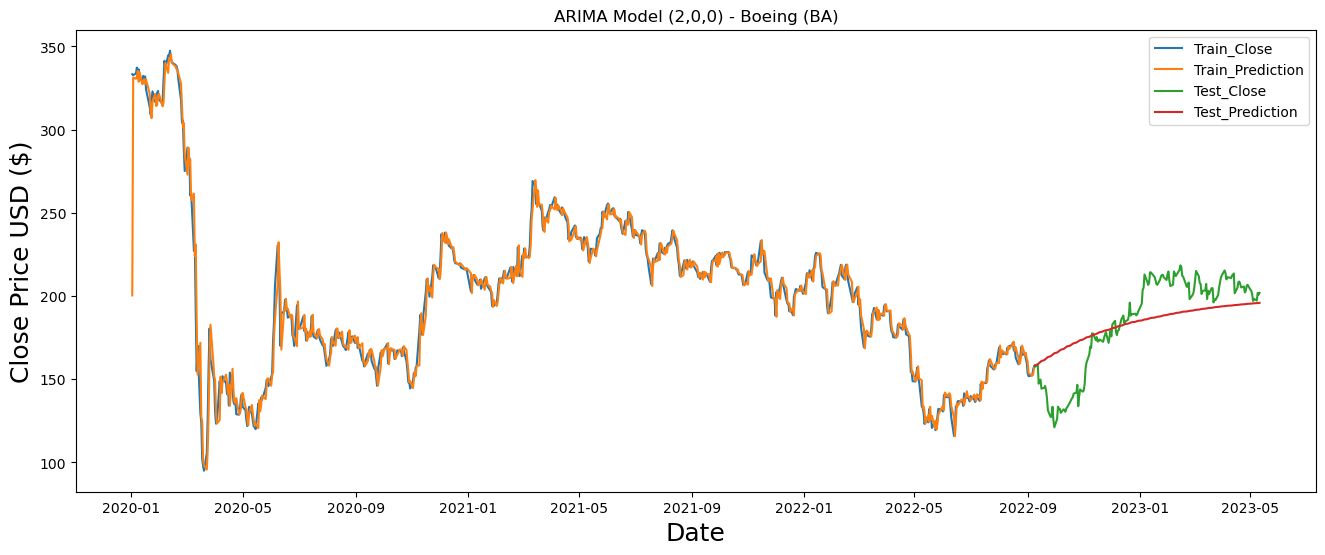

In [45]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('ARIMA Model (2,0,0) - Boeing (BA)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_val_ba[['Close', 'Prediction']])
plt.plot(test_ba[['Close', 'Prediction']])
plt.legend(['Train_Close', 'Train_Prediction','Test_Close', 'Test_Prediction'], loc='upper right')
#plt.show()
plt.savefig("images/Boeing_Company_(BA)_ARIMA_2")

In [46]:
pm.arima.auto_arima(train_ba_lgp)

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [47]:
p, d, q = 0, 1, 2
ar_model_ba = ARIMA(train_ba_lgp['Close'], order=(p, d, q))
ar_model_ba = ar_model_ba.fit()
ar_model_ba.summary()

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  677
Model:                 ARIMA(0, 1, 2)   Log Likelihood                1237.748
Date:                Fri, 15 Dec 2023   AIC                          -2469.496
Time:                        20:05:01   BIC                          -2455.947
Sample:                             0   HQIC                         -2464.250
                                - 677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0720      0.017      4.190      0.000       0.038       0.106
ma.L2          0.1834      0.020      9.382      0.000       0.145       0.222
sigma2         0.0015   4.19e-05     35.863      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1446.36
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
# Set the significance level (alpha)
alpha = 0.05

p_values = ar_model_ba.pvalues

significant_predictors = p_values[p_values <= alpha]

print("Significant Predictors:")
print(significant_predictors)

Significant Predictors:
ma.L1      2.794185e-05
ma.L2      6.489390e-21
sigma2    1.167885e-281
dtype: float64


In [49]:
predicted_original_train_ba = ar_model_ba.predict(start=train_ba_lgp.index[0], 
                                                  end=train_ba_lgp.index[-1], 
                                                  dynamic=False)
predicted_original_train_ba = np.exp(predicted_original_train_ba)
#predicted_original_ba = np.array(predicted_original_ba)
predicted_original_train_ba = pd.DataFrame(predicted_original_train_ba)

train_val_ba = ba[:int(training_ba_len)]
train_val_ba = pd.merge(train_val_ba, predicted_original_train_ba, 
                        left_index=True, right_index=True)
train_val_ba = train_val_ba.rename(columns={'predicted_mean': 'Prediction'})
train_val_ba

,Close,Prediction
Date,,
2020-01-02,333.320007,1.000000
2020-01-03,332.760010,333.320008
2020-01-06,333.739990,332.714107
2020-01-07,337.279999,333.710779
2020-01-08,331.369995,337.725523
...,...,...
2022-09-01,153.660004,159.728619
2022-09-02,151.820007,152.904828
2022-09-06,152.389999,150.667790


In [50]:
train_mse = mean_squared_error(train_val_ba['Close'], train_val_ba['Prediction'])
train_rmse = np.sqrt(train_mse)
print("The MSE of the Trainning set is", train_mse)
print("The RMSE of the Trainning set is", train_rmse)

The MSE of the Trainning set is 210.62604708648428
The RMSE of the Trainning set is 14.512961347929108


In [51]:
# Create the scaled training data set
test_ba = ba[int(training_ba_len):]
# Log price
test_ba_lgp = np.log(test_ba)

forecast_ba = ar_model_ba.get_forecast(steps=len(test_ba_lgp))

predicted_values_ba = forecast_ba.predicted_mean
predicted_original_ba = np.exp(predicted_values_ba)
predicted_original_ba = np.array(predicted_original_ba)
predicted_original_ba = pd.DataFrame(index=test_ba_lgp.index, columns=['Prediction'], 
                                     data=predicted_original_ba)

test_ba = pd.merge(test_ba, predicted_original_ba, 
                   left_index=True, right_index=True)
test_ba

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Close,Prediction
Date,,
2022-09-09,157.520004,158.564732
2022-09-12,158.720001,158.796043
2022-09-13,147.309998,158.796043
2022-09-14,149.259995,158.796043
2022-09-15,149.779999,158.796043
...,...,...
2023-05-05,198.339996,158.796043
2023-05-08,197.259995,158.796043
2023-05-09,201.880005,158.796043


In [52]:
test_mse = mean_squared_error(test_ba['Close'], test_ba['Prediction'])
test_rmse = np.sqrt(test_mse)
print("The MSE of the Test set is", test_mse)
print("The RMSE of the Test set is", test_rmse)

The MSE of the Test set is 1491.442976445892
The RMSE of the Test set is 38.61920476195609


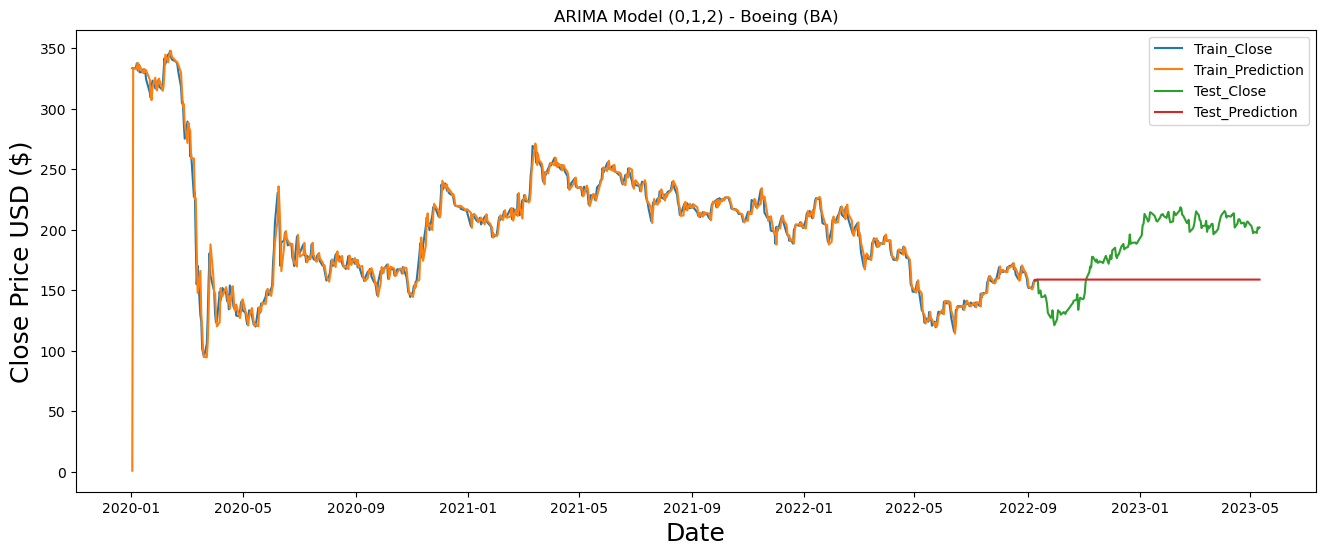

In [53]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('ARIMA Model (0,1,2) - Boeing (BA)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_val_ba[['Close', 'Prediction']])
plt.plot(test_ba[['Close', 'Prediction']])
plt.legend(['Train_Close', 'Train_Prediction','Test_Close', 'Test_Prediction'], loc='upper right')
#plt.show()
plt.savefig("images/Boeing_Company_(BA)_ARIMA_3")

In [54]:
p, d, q = 4, 1, 6
ar_model_ba = ARIMA(train_ba_lgp['Close'], order=(p, d, q))
ar_model_ba = ar_model_ba.fit()
ar_model_ba.summary()

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  677
Model:                 ARIMA(4, 1, 6)   Log Likelihood                1246.302
Date:                Fri, 15 Dec 2023   AIC                          -2470.604
Time:                        20:05:03   BIC                          -2420.926
Sample:                             0   HQIC                         -2451.370
                                - 677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5023      0.071     -7.026      0.000      -0.642      -0.362
ar.L2          0.6586      0.077      8.539      0.000       0.507       0.810
ar.L3         -0.4637      0.066     -7.073      0.000      -0.592      -0.335
ar.L4         -0.8479      0.062    -13.669      0.000      -0.969      -0.726
ma.L1          0.5777      0.074      7.776      0.000       0.432       0.723
ma.L2         -0.4433      0.082     -5.402      0.000      -0.604      -0.282
ma.L3          0.5144      0.069      7.415      0.000       0.378       0.650
ma.L4          0.7332      0.073     10.104      0.000       0.591       0.875
ma.L5          0.1076      0.035      3.058      0.002       0.039       0.177
ma.L6          0.1051      0.037      2.819      0.005       0.032       0.178
sigma2         0.0015   4.67e-05     31.334      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1253.46
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
# Set the significance level (alpha)
alpha = 0.05

p_values = ar_model_ba.pvalues

significant_predictors = p_values[p_values <= alpha]

print("Significant Predictors:")
print(significant_predictors)

Significant Predictors:
ar.L1      2.127745e-12
ar.L2      1.358088e-17
ar.L3      1.515523e-12
ar.L4      1.563808e-42
ma.L1      7.455934e-15
ma.L2      6.600023e-08
ma.L3      1.212720e-13
ma.L4      5.302499e-24
ma.L5      2.226047e-03
ma.L6      4.812607e-03
sigma2    1.630318e-215
dtype: float64


In [56]:
predicted_original_train_ba = ar_model_ba.predict(start=train_ba_lgp.index[0], 
                                                  end=train_ba_lgp.index[-1], 
                                                  dynamic=False)
predicted_original_train_ba = np.exp(predicted_original_train_ba)
#predicted_original_ba = np.array(predicted_original_ba)
predicted_original_train_ba = pd.DataFrame(predicted_original_train_ba)

train_val_ba = ba[:int(training_ba_len)]
train_val_ba = pd.merge(train_val_ba, predicted_original_train_ba, 
                        left_index=True, right_index=True)
train_val_ba = train_val_ba.rename(columns={'predicted_mean': 'Prediction'})
train_val_ba

,Close,Prediction
Date,,
2020-01-02,333.320007,1.000000
2020-01-03,332.760010,333.320008
2020-01-06,333.739990,332.718327
2020-01-07,337.279999,333.703758
2020-01-08,331.369995,337.720118
...,...,...
2022-09-01,153.660004,159.292708
2022-09-02,151.820007,153.214733
2022-09-06,152.389999,151.324491


In [57]:
train_mse = mean_squared_error(train_val_ba['Close'], train_val_ba['Prediction'])
train_rmse = np.sqrt(train_mse)
print("The MSE of the Trainning set is", train_mse)
print("The RMSE of the Trainning set is", train_rmse)

The MSE of the Trainning set is 209.78057389758536
The RMSE of the Trainning set is 14.483803847663271


In [58]:
# Create the scaled training data set
test_ba = ba[int(training_ba_len):]
# Log price
test_ba_lgp = np.log(test_ba)

forecast_ba = ar_model_ba.get_forecast(steps=len(test_ba_lgp))

predicted_values_ba = forecast_ba.predicted_mean
predicted_original_ba = np.exp(predicted_values_ba)
predicted_original_ba = np.array(predicted_original_ba)
predicted_original_ba = pd.DataFrame(index=test_ba_lgp.index, columns=['Prediction'], 
                                     data=predicted_original_ba)

test_ba = pd.merge(test_ba, predicted_original_ba, 
                   left_index=True, right_index=True)
test_ba

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Close,Prediction
Date,,
2022-09-09,157.520004,157.986055
2022-09-12,158.720001,158.615432
2022-09-13,147.309998,157.291470
2022-09-14,149.259995,157.533607
2022-09-15,149.779999,156.511250
...,...,...
2023-05-05,198.339996,157.562173
2023-05-08,197.259995,157.563195
2023-05-09,201.880005,157.563325


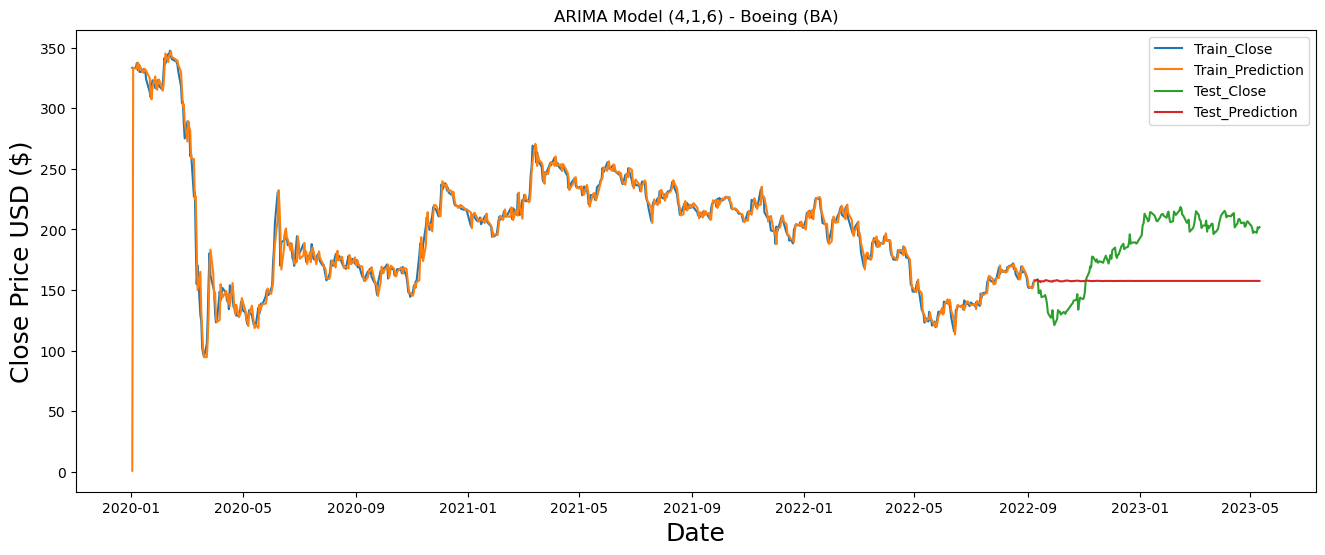

In [59]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('ARIMA Model (4,1,6) - Boeing (BA)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_val_ba[['Close', 'Prediction']])
plt.plot(test_ba[['Close', 'Prediction']])
plt.legend(['Train_Close', 'Train_Prediction','Test_Close', 'Test_Prediction'], loc='upper right')
#plt.show()
plt.savefig("images/Boeing_Company_(BA)_ARIMA_4")

### Zoom (ZM)

In [60]:
# Get the number of rows to train the model on
training_zm_len = int(np.ceil(len(zm) * .8 ))
# Create the scaled training data set
train_zm = zm[0:int(training_zm_len)]
# First-order differencing
train_zm_diff = train_zm.diff().dropna()
# Log price 
train_zm_lgp = np.log(train_zm)
# Log Returns 
train_zm_rtn = np.log(train_zm).diff().dropna()

### 1. Find d in (p, d, q) for ARIMA model and (ADF) test

In [61]:
# ZM Pirce d=0
result = adfuller(train_zm)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.091567
p-value: 0.718423
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [62]:
# ZM Pirce d=1
result = adfuller(train_zm_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.269873
p-value: 0.000000
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [63]:
# ZM Log Pirce d=0
result = adfuller(train_zm_lgp)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.248085
p-value: 0.652576
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [64]:
# ZM Log Pirce d=1
result = adfuller(train_zm_rtn)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -26.131050
p-value: 0.000000
	1%: -3.440
	5%: -2.866
	10%: -2.569


### Choose ZM Log Pirce d=1, use train_zm_lgp (log price of ZM) d=1 in ARIMA Model

### 2. Find p and q in (p, d, q) for ARIMA model
### Method 1, Step 1: ACF plot and PACF plot

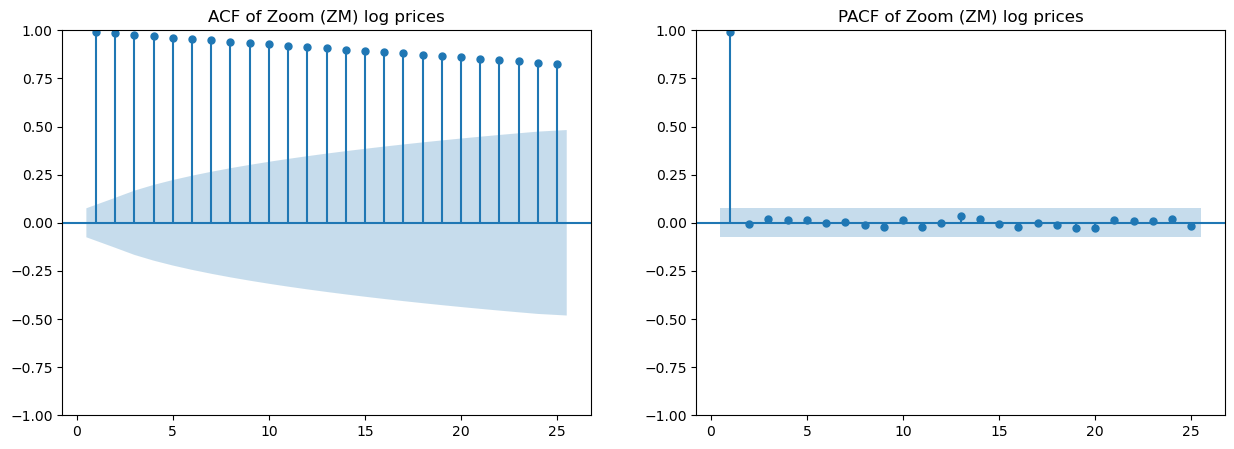

In [65]:
plot_ACF_PACF(train_zm_lgp, 25, 'Zoom (ZM)')
#plt.savefig("images/Zoom_(ZM)_ACF_PACF")

### p=0, q=0

In [66]:
p, d, q = 0, 1, 0
ar_model_zm = ARIMA(train_zm_lgp['Close'], order=(p, d, q))
ar_model_zm = ar_model_zm.fit()
ar_model_zm.summary()

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  677
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1160.345
Date:                Fri, 15 Dec 2023   AIC                          -2318.689
Time:                        20:05:06   BIC                          -2314.173
Sample:                             0   HQIC                         -2316.941
                                - 677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0019   4.69e-05     40.301      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1646.47
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Method 1, Step 2: p-value test

In [67]:
# Set the significance level (alpha)
alpha = 0.05

p_values = ar_model_zm.pvalues

significant_predictors = p_values[p_values <= alpha]

print("Significant Predictors:")
print(significant_predictors)

Significant Predictors:
sigma2    0.0
dtype: float64


### 2. Find p and q in (p, d, q) for ARIMA model
### Method 2: grid search for min AIC and min BIC

In [68]:
result_df = searchARIMA(train_zm_lgp.values, d = 1, max_p = 10, max_q = 10)
result_df

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarni

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarni

,p,q,aic,bic
0,0,0,-2318.689199,-2314.173006
1,0,1,-2316.725490,-2307.693104
2,0,2,-2315.648769,-2302.100190
3,0,3,-2313.926836,-2295.862063
4,0,4,-2312.859576,-2290.278611
...,...,...,...,...
95,9,5,-2296.018761,-2228.275865
96,9,6,-2298.606085,-2226.346996
97,9,7,-2293.419767,-2216.644485
98,9,8,-2291.103879,-2209.812404


In [69]:
min_aic_bic_row = result_df[(result_df['aic'] == result_df['aic'].min()) |
                            (result_df['bic'] == result_df['bic'].min())]
min_aic_bic_row

,p,q,aic,bic
0,0,0,-2318.689199,-2314.173006


In [70]:
pm.arima.auto_arima(train_zm_lgp)

ARIMA(order=(4, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### In general, choose p=0, q=0

In [71]:
p, d, q = 0, 1, 0
ar_model_zm = ARIMA(train_zm_lgp['Close'], order=(p, d, q))
ar_model_zm = ar_model_zm.fit()
ar_model_zm.summary()

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  677
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1160.345
Date:                Fri, 15 Dec 2023   AIC                          -2318.689
Time:                        20:07:11   BIC                          -2314.173
Sample:                             0   HQIC                         -2316.941
                                - 677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0019   4.69e-05     40.301      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1646.47
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
# Set the significance level (alpha)
alpha = 0.05

p_values = ar_model_zm.pvalues

significant_predictors = p_values[p_values <= alpha]

print("Significant Predictors:")
print(significant_predictors)

Significant Predictors:
sigma2    0.0
dtype: float64


In [73]:
predicted_original_train_zm = ar_model_zm.predict(start=train_zm_lgp.index[0], 
                                                  end=train_zm_lgp.index[-1], 
                                                  dynamic=False)
predicted_original_train_zm = np.exp(predicted_original_train_zm)
#predicted_original_ba = np.array(predicted_original_ba)

In [74]:
predicted_original_train_zm = pd.DataFrame(predicted_original_train_zm)

train_val_zm = zm[:int(training_zm_len)]
train_val_zm = pd.merge(train_val_zm, predicted_original_train_zm, 
                        left_index=True, right_index=True)
train_val_zm = train_val_zm.rename(columns={'predicted_mean': 'Prediction'})
train_val_zm

,Close,Prediction
Date,,
2020-01-02,68.720001,1.000000
2020-01-03,67.279999,68.720001
2020-01-06,70.320000,67.279999
2020-01-07,71.900002,70.320000
2020-01-08,72.550003,71.900002
...,...,...
2022-09-01,81.139999,80.400002
2022-09-02,80.790001,81.139999
2022-09-06,80.019997,80.790001


In [75]:
train_mse = mean_squared_error(train_val_zm['Close'], train_val_zm['Prediction'])
train_rmse = np.sqrt(train_mse)
print("The MSE of the Trainning set is", train_mse)
print("The RMSE of the Trainning set is", train_rmse)

The MSE of the Trainning set is 153.99022624434983
The RMSE of the Trainning set is 12.409279843905118


In [76]:
# Create the scaled training data set
test_zm = zm[int(training_zm_len):]
# Log price
test_zm_lgp = np.log(test_zm)

forecast_zm = ar_model_zm.get_forecast(steps=len(test_zm_lgp))

predicted_values_zm = forecast_zm.predicted_mean
predicted_original_zm = np.exp(predicted_values_zm)
predicted_original_zm = np.array(predicted_original_zm)

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [77]:
predicted_original_zm = pd.DataFrame(index=test_zm_lgp.index, columns=['Prediction'], 
                                     data=predicted_original_zm)

test_zm = pd.merge(test_zm, predicted_original_zm, 
                   left_index=True, right_index=True)
test_zm

,Close,Prediction
Date,,
2022-09-09,82.620003,80.230003
2022-09-12,84.080002,80.230003
2022-09-13,78.860001,80.230003
2022-09-14,79.589996,80.230003
2022-09-15,80.209999,80.230003
...,...,...
2023-05-05,63.400002,80.230003
2023-05-08,62.930000,80.230003
2023-05-09,63.560001,80.230003


In [78]:
test_mse = mean_squared_error(test_zm['Close'], test_zm['Prediction'])
test_rmse = np.sqrt(test_mse)
print("The MSE of the Test set is", test_mse)
print("The RMSE of the Test set is", test_rmse)

The MSE of the Test set is 87.11304903815056
The RMSE of the Test set is 9.333437150275913


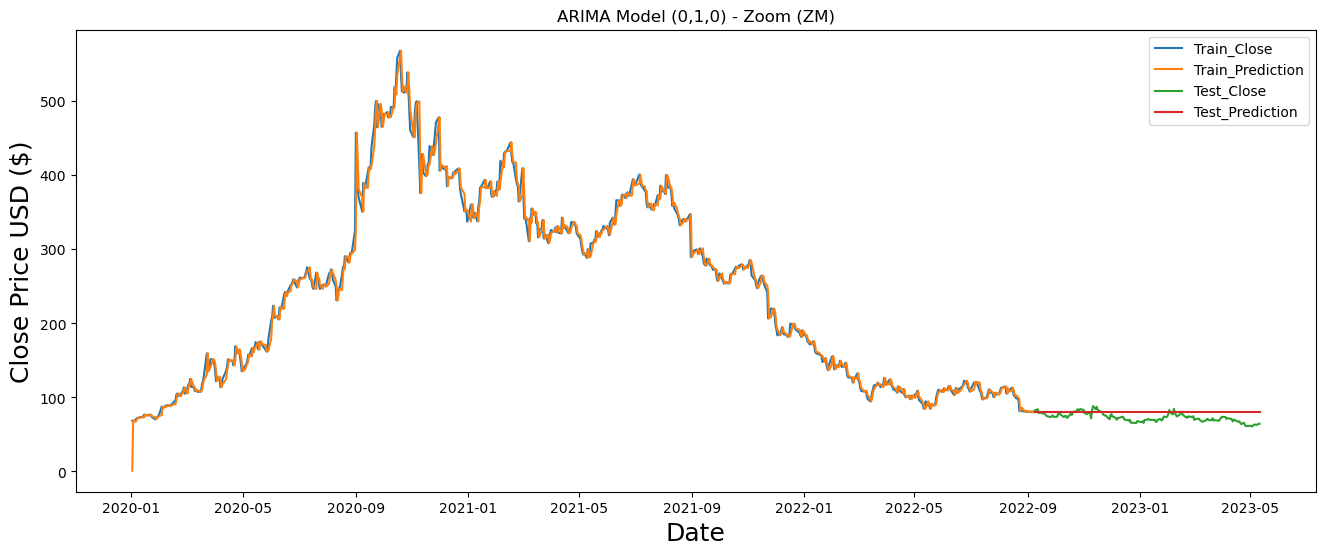

In [79]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('ARIMA Model (0,1,0) - Zoom (ZM)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_val_zm[['Close', 'Prediction']])
plt.plot(test_zm[['Close', 'Prediction']])
plt.legend(['Train_Close', 'Train_Prediction','Test_Close', 'Test_Prediction'], loc='upper right')
#plt.show()
plt.savefig("images/Zoom_(ZM)_ARIMA_1")

In [80]:
pm.arima.auto_arima(train_zm_lgp)

ARIMA(order=(4, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [81]:
p, d, q = 4, 2, 1
ar_model_zm = ARIMA(train_zm_lgp['Close'], order=(p, d, q))
ar_model_zm = ar_model_zm.fit()
ar_model_zm.summary()

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  677
Model:                 ARIMA(4, 2, 1)   Log Likelihood                1160.709
Date:                Fri, 15 Dec 2023   AIC                          -2309.418
Time:                        20:07:20   BIC                          -2282.329
Sample:                             0   HQIC                         -2298.929
                                - 677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0289      0.029     -1.000      0.317      -0.085       0.028
ar.L2         -0.0563      0.034     -1.658      0.097      -0.123       0.010
ar.L3         -0.0388      0.038     -1.010      0.312      -0.114       0.037
ar.L4         -0.0607      0.037     -1.654      0.098      -0.133       0.011
ma.L1         -0.9878      0.008   -127.046      0.000      -1.003      -0.973
sigma2         0.0019   4.93e-05     37.914      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1609.25
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
# Set the significance level (alpha)
alpha = 0.05

p_values = ar_model_zm.pvalues

significant_predictors = p_values[p_values <= alpha]

print("Significant Predictors:")
print(significant_predictors)

Significant Predictors:
ma.L1     0.0
sigma2    0.0
dtype: float64


In [83]:
# p, d, q = 0, 2, 1
# ar_model_zm = ARIMA(train_zm_lgp['Close'], order=(p, d, q))
# ar_model_zm = ar_model_zm.fit()
# ar_model_zm.summary()

In [84]:
# # Set the significance level (alpha)
# alpha = 0.05

# p_values = ar_model_zm.pvalues

# significant_predictors = p_values[p_values <= alpha]

# print("Significant Predictors:")
# print(significant_predictors)

In [85]:
predicted_original_train_zm = ar_model_zm.predict(start=train_zm_lgp.index[0], 
                                                  end=train_zm_lgp.index[-1], 
                                                  dynamic=False)
predicted_original_train_zm = np.exp(predicted_original_train_zm)
#predicted_original_ba = np.array(predicted_original_ba)
predicted_original_train_zm = pd.DataFrame(predicted_original_train_zm)

train_val_zm = zm[:int(training_zm_len)]
train_val_zm = pd.merge(train_val_zm, predicted_original_train_zm, 
                        left_index=True, right_index=True)
train_val_zm = train_val_zm.rename(columns={'predicted_mean': 'Prediction'})
train_val_zm

,Close,Prediction
Date,,
2020-01-02,68.720001,1.000000
2020-01-03,67.279999,569.671822
2020-01-06,70.320000,65.870172
2020-01-07,71.900002,71.198084
2020-01-08,72.550003,72.942304
...,...,...
2022-09-01,81.139999,80.197569
2022-09-02,80.790001,80.716940
2022-09-06,80.019997,80.308033


In [86]:
train_mse = mean_squared_error(train_val_zm['Close'], train_val_zm['Prediction'])
train_rmse = np.sqrt(train_mse)
print("The MSE of the Trainning set is", train_mse)
print("The RMSE of the Trainning set is", train_rmse)

The MSE of the Trainning set is 526.7243910126432
The RMSE of the Trainning set is 22.95047692342456


In [87]:
# Create the scaled training data set
test_zm = zm[int(training_zm_len):]
# Log price
test_zm_lgp = np.log(test_zm)

forecast_zm = ar_model_zm.get_forecast(steps=len(test_zm_lgp))

predicted_values_zm = forecast_zm.predicted_mean
predicted_original_zm = np.exp(predicted_values_zm)
predicted_original_zm = np.array(predicted_original_zm)
predicted_original_zm = pd.DataFrame(index=test_zm_lgp.index, columns=['Prediction'], 
                                     data=predicted_original_zm)

test_zm = pd.merge(test_zm, predicted_original_zm, 
                   left_index=True, right_index=True)
test_zm

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Close,Prediction
Date,,
2022-09-09,82.620003,79.795424
2022-09-12,84.080002,79.410065
2022-09-13,78.860001,78.968458
2022-09-14,79.589996,78.621022
2022-09-15,80.209999,78.253175
...,...,...
2023-05-05,63.400002,36.491449
2023-05-08,62.930000,36.317871
2023-05-09,63.560001,36.145119


In [88]:
test_mse = mean_squared_error(test_zm['Close'], test_zm['Prediction'])
test_rmse = np.sqrt(test_mse)
print("The MSE of the Test set is", test_mse)
print("The RMSE of the Test set is", test_rmse)

The MSE of the Test set is 426.70324320475163
The RMSE of the Test set is 20.656796537816593


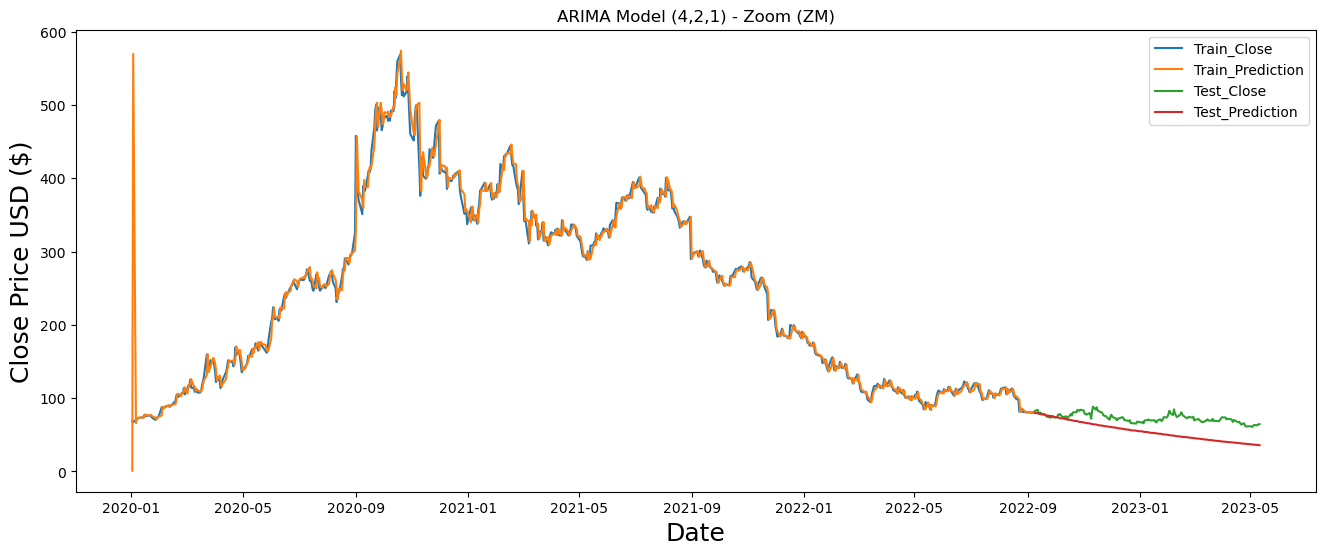

In [89]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('ARIMA Model (4,2,1) - Zoom (ZM)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_val_zm[['Close', 'Prediction']])
plt.plot(test_zm[['Close', 'Prediction']])
plt.legend(['Train_Close', 'Train_Prediction','Test_Close', 'Test_Prediction'], loc='upper right')
#plt.show()
plt.savefig("images/Zoom_(ZM)_ARIMA_2")

## LSTM

### Step 1: Normalize your data into interval [0,1] (recommend using MinMaxScaler from sklearn.preprocessing)

In [90]:
scaler_ba = MinMaxScaler(feature_range=(0,1))
scaled_ba = scaler_ba.fit_transform(ba)

In [91]:
scaler_zm = MinMaxScaler(feature_range=(0,1))
scaled_zm = scaler_zm.fit_transform(zm)

### Step 2: Set 80% of the data as training data and 20% of the data as the testing set

In [92]:
# Get the number of rows to train the model on
training_ba_len = int(np.ceil( len(scaled_ba) * .8 ))

training_ba_len

677

In [93]:
# Create the scaled training data set
train_ba = scaled_ba[0:int(training_ba_len), :]

In [94]:
# Get the number of rows to train the model on
training_zm_len = int(np.ceil( len(scaled_zm) * .8 ))

training_zm_len

677

In [95]:
# Create the scaled training data set
train_zm = scaled_zm[0:int(training_zm_len), :]

### Step 3: Pick a lookback window with 10 timestamps

In [96]:
def Split_train_data_with_lookback_window(train_data, timestamps):
    x_train = []
    y_train = []
    
    for i in range(timestamps, len(train_data)):
        x_train.append(train_data[i-10:i, 0])
        y_train.append(train_data[i, 0])
        if i<= timestamps+1:
            print(x_train)
            print(y_train)
            print()
            
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    return x_train, y_train

In [97]:
x_train_ba, y_train_ba = Split_train_data_with_lookback_window(train_ba, 10)

[array([0.94402629, 0.94180795, 0.94568998, 0.95971315, 0.93630163,
       0.95598948, 0.93055776, 0.93174612, 0.94018378, 0.9300823 ])]
[0.9387972920667447]

[array([0.94402629, 0.94180795, 0.94568998, 0.95971315, 0.93630163,
       0.95598948, 0.93055776, 0.93174612, 0.94018378, 0.9300823 ]), array([0.94180795, 0.94568998, 0.95971315, 0.93630163, 0.95598948,
       0.93055776, 0.93174612, 0.94018378, 0.9300823 , 0.93879729])]
[0.9387972920667447, 0.9077007709514351]



In [98]:
x_train_zm, y_train_zm = Split_train_data_with_lookback_window(train_zm, 10)

[array([0.01556589, 0.01272856, 0.01871847, 0.02183165, 0.0231124 ,
       0.02325032, 0.02417638, 0.02602853, 0.02431432, 0.0317623 ])]
[0.030126891742712686]

[array([0.01556589, 0.01272856, 0.01871847, 0.02183165, 0.0231124 ,
       0.02325032, 0.02417638, 0.02602853, 0.02431432, 0.0317623 ]), array([0.01272856, 0.01871847, 0.02183165, 0.0231124 , 0.02325032,
       0.02417638, 0.02602853, 0.02431432, 0.0317623 , 0.03012689])]
[0.030126891742712686, 0.029043184652699228]



### Specify the LSTM model with the following parameters:

In [99]:
# Build the LSTM model
lstm_model_ba = Sequential()
lstm_model_ba.add(LSTM(4, input_shape= (x_train_ba.shape[1], 1)))
lstm_model_ba.add(Dense(1))
# Compile the model
lstm_model_ba.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = lstm_model_ba.fit(x_train_ba, y_train_ba, batch_size=256, epochs=100, verbose=2)

Epoch 1/100
3/3 - 5s - loss: 0.1949 - 5s/epoch - 2s/step
Epoch 2/100
3/3 - 0s - loss: 0.1821 - 16ms/epoch - 5ms/step
Epoch 3/100
3/3 - 0s - loss: 0.1700 - 31ms/epoch - 10ms/step
Epoch 4/100
3/3 - 0s - loss: 0.1581 - 16ms/epoch - 5ms/step
Epoch 5/100
3/3 - 0s - loss: 0.1467 - 16ms/epoch - 5ms/step
Epoch 6/100
3/3 - 0s - loss: 0.1357 - 16ms/epoch - 5ms/step
Epoch 7/100
3/3 - 0s - loss: 0.1250 - 16ms/epoch - 5ms/step
Epoch 8/100
3/3 - 0s - loss: 0.1150 - 16ms/epoch - 5ms/step
Epoch 9/100
3/3 - 0s - loss: 0.1050 - 31ms/epoch - 10ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0958 - 31ms/epoch - 10ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0869 - 16ms/epoch - 5ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0785 - 31ms/epoch - 10ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0704 - 16ms/epoch - 5ms/step
Epoch 14/100
3/3 - 0s - loss: 0.0630 - 16ms/epoch - 5ms/step
Epoch 15/100
3/3 - 0s - loss: 0.0560 - 16ms/epoch - 5ms/step
Epoch 16/100
3/3 - 0s - loss: 0.0494 - 16ms/epoch - 5ms/step
Epoch 17/100
3/3 - 0s - loss: 0.

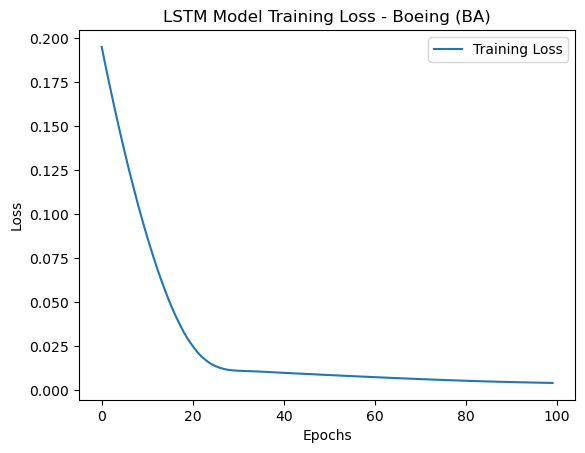

In [100]:
# Plot the training loss - Convergence
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Training Loss - Boeing (BA)')
plt.legend()
#plt.show()
plt.savefig("images/LSTM Model Trainning Loss - Boeing (BA)")

In [101]:
# Build the LSTM model
lstm_model_zm = Sequential()
lstm_model_zm.add(LSTM(4, input_shape= (x_train_zm.shape[1], 1)))
lstm_model_zm.add(Dense(1))
# Compile the model
lstm_model_zm.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = lstm_model_zm.fit(x_train_zm, y_train_zm, batch_size=256, epochs=100, verbose=2)

Epoch 1/100
3/3 - 3s - loss: 0.0947 - 3s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.0869 - 16ms/epoch - 5ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0795 - 16ms/epoch - 5ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0725 - 31ms/epoch - 10ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0655 - 16ms/epoch - 5ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0592 - 16ms/epoch - 5ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0532 - 31ms/epoch - 10ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0474 - 24ms/epoch - 8ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0423 - 16ms/epoch - 5ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0373 - 16ms/epoch - 5ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0331 - 16ms/epoch - 5ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0292 - 16ms/epoch - 5ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0257 - 16ms/epoch - 5ms/step
Epoch 14/100
3/3 - 0s - loss: 0.0229 - 31ms/epoch - 10ms/step
Epoch 15/100
3/3 - 0s - loss: 0.0204 - 16ms/epoch - 5ms/step
Epoch 16/100
3/3 - 0s - loss: 0.0184 - 16ms/epoch - 5ms/step
Epoch 17/100
3/3 - 0s - loss: 0.0

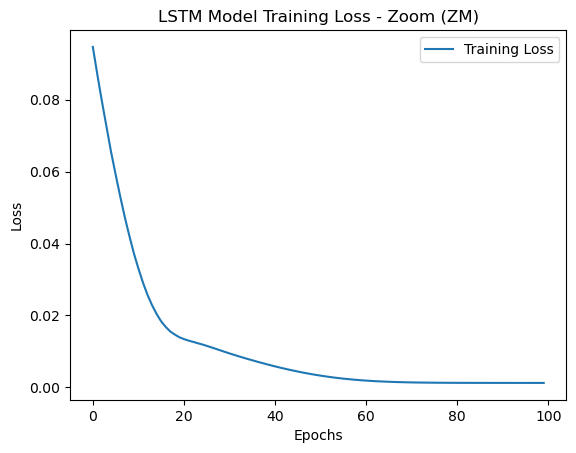

In [102]:
# Plot the training loss 
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Training Loss - Zoom (ZM)')
plt.legend()
#plt.show()
plt.savefig("images/LSTM Model Trainning Loss - Zoom (ZM)")

### Train set predictions and RMSE

In [103]:
y_train_ba = ba[10:training_ba_len].values

In [104]:
# Get the models predicted price values 
train_pred_ba = lstm_model_ba.predict(x_train_ba)
train_pred_ba = scaler_ba.inverse_transform(train_pred_ba)

# Get the root mean squared error (RMSE)
train_rmse_ba = np.sqrt(np.mean(((train_pred_ba - y_train_ba) ** 2)))
train_rmse_ba

21/21 [==============================] - 1s 2ms/step


16.034497635163348

In [105]:
train_val_ba = ba[10:training_ba_len]
train_val_ba['Prediction'] = train_pred_ba
train_val_ba

,Close,Prediction
Date,,
2020-01-16,332.000000,303.658203
2020-01-17,324.149994,303.537445
2020-01-21,313.369995,303.064972
2020-01-22,309.000000,301.855530
2020-01-23,317.790009,300.105621
...,...,...
2022-09-01,153.660004,169.883011
2022-09-02,151.820007,168.658813
2022-09-06,152.389999,167.570267


In [106]:
train_mse = mean_squared_error(train_val_ba['Close'], train_val_ba['Prediction'])
train_rmse = np.sqrt(train_mse)
print("The MSE of the Training set is", train_mse)
print("The RMSE of the Training set is", train_rmse)

The MSE of the Training set is 257.10511441205904
The RMSE of the Training set is 16.034497635163348


In [107]:
y_train_zm = zm[10:training_zm_len].values

In [108]:
# Get the models predicted price values 
train_pred_zm = lstm_model_zm.predict(x_train_zm)
train_pred_zm = scaler_zm.inverse_transform(train_pred_zm)

# Get the root mean squared error (RMSE)
train_rmse_zm = np.sqrt(np.mean(((train_pred_zm - y_train_zm) ** 2)))
train_rmse_zm

21/21 [==============================] - 1s 2ms/step


17.990990910365824

In [109]:
train_val_zm = zm[10:training_zm_len]
train_val_zm['Prediction'] = train_pred_zm
train_val_zm

,Close,Prediction
Date,,
2020-01-16,76.110001,80.820297
2020-01-17,75.559998,81.387871
2020-01-21,76.730003,81.700119
2020-01-22,75.540001,82.171432
2020-01-23,74.470001,82.221657
...,...,...
2022-09-01,81.139999,88.512329
2022-09-02,80.790001,87.850410
2022-09-06,80.019997,87.322151


In [110]:
train_mse = mean_squared_error(train_val_zm['Close'], train_val_zm['Prediction'])
train_rmse = np.sqrt(train_mse)
print("The MSE of the Training set is", train_mse)
print("The RMSE of the Training set is", train_rmse)

The MSE of the Training set is 323.67575393686565
The RMSE of the Training set is 17.990990910365824


### Get Test set and Split to X and y

In [111]:
# get test data set and split into X and y
def Split_test_data_with_lookback_window(scaled_data, original_data, training_data_len, timestamps):
    # Create the testing data set
    test_data = scaled_data[training_data_len - 10: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = original_data[training_data_len:].values
    
    for i in range(timestamps, len(test_data)):
        x_test.append(test_data[i-timestamps:i, 0])

    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    
    return x_test, y_test

In [112]:
x_test_ba, y_test_ba = Split_test_data_with_lookback_window(scaled_ba, ba, training_ba_len, 10)

In [113]:
x_test_zm, y_test_zm, = Split_test_data_with_lookback_window(scaled_zm, zm, training_zm_len, 10)

### Prediction

In [114]:
# Get the models predicted price values 
pred_ba = lstm_model_ba.predict(x_test_ba)
pred_ba = scaler_ba.inverse_transform(pred_ba)

# Get MSE and RMSE
test_mse_ba = np.mean(((pred_ba - y_test_ba) ** 2))
test_rmse_ba = np.sqrt(test_mse_ba)
print("The MSE of the Test set is", test_mse_ba)
print("The RMSE of the Test set is", test_rmse_ba)

6/6 [==============================] - 0s 3ms/step
The MSE of the Test set is 85.99911155398644
The RMSE of the Test set is 9.273570593573245


In [115]:
test_ba = ba[training_ba_len:]
test_ba['Prediction'] = pred_ba
test_ba

,Close,Prediction
Date,,
2022-09-09,157.520004,165.988541
2022-09-12,158.720001,165.416107
2022-09-13,147.309998,165.229538
2022-09-14,149.259995,163.906128
2022-09-15,149.779999,163.000687
...,...,...
2023-05-05,198.339996,201.929199
2023-05-08,197.259995,201.254028
2023-05-09,201.880005,200.478256


In [116]:
# Get the models predicted price values 
pred_zm = lstm_model_zm.predict(x_test_zm)
pred_zm = scaler_zm.inverse_transform(pred_zm)

# Get MSE and RMSE
test_mse_zm = np.mean(((pred_zm - y_test_zm) ** 2))
test_rmse_zm = np.sqrt(test_mse_zm)
print("The MSE of the Test set is", test_mse_zm)
print("The RMSE of the Test set is", test_rmse_zm)

6/6 [==============================] - 0s 0s/step
The MSE of the Test set is 62.43103856710199
The RMSE of the Test set is 7.901331442681164


In [117]:
test_zm = zm[training_zm_len:]
test_zm['Prediction'] = pred_zm
test_zm

,Close,Prediction
Date,,
2022-09-09,82.620003,86.598473
2022-09-12,84.080002,86.986015
2022-09-13,78.860001,87.658127
2022-09-14,79.589996,86.942780
2022-09-15,80.209999,86.589653
...,...,...
2023-05-05,63.400002,70.692055
2023-05-08,62.930000,71.057541
2023-05-09,63.560001,71.193703


### Plot the true and the predicted price sequences during the training period plus the testing period

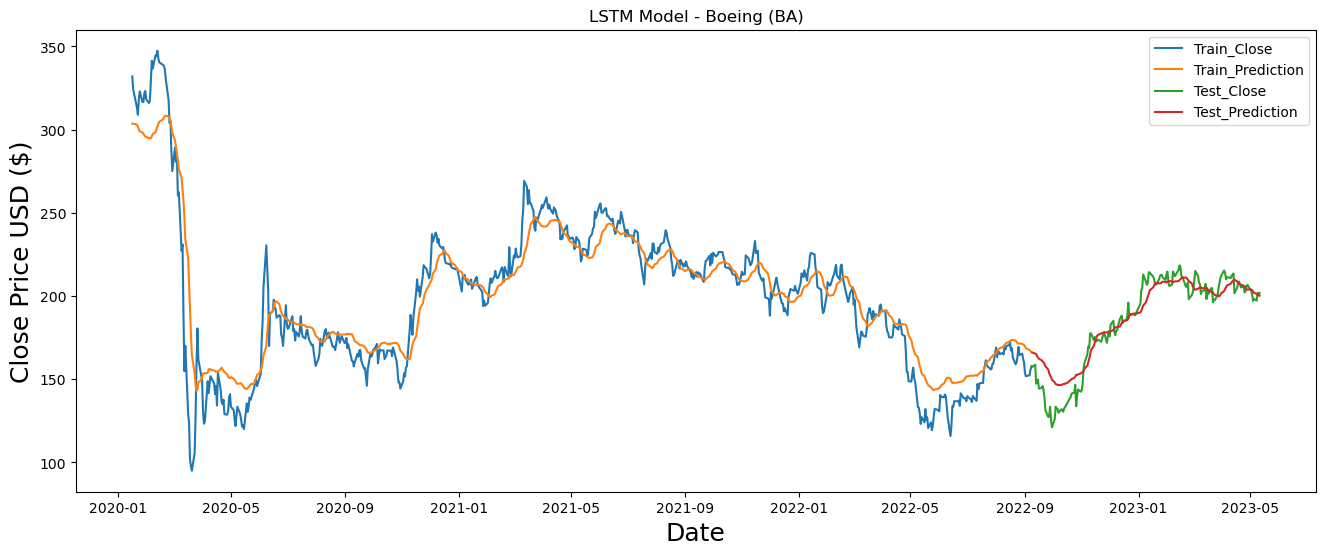

In [118]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('LSTM Model - Boeing (BA)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_val_ba[['Close', 'Prediction']])
plt.plot(test_ba[['Close', 'Prediction']])
plt.legend(['Train_Close', 'Train_Prediction','Test_Close', 'Test_Prediction'], loc='upper right')
#plt.show()
plt.savefig("images/LSTM Model - Boeing (BA)") 

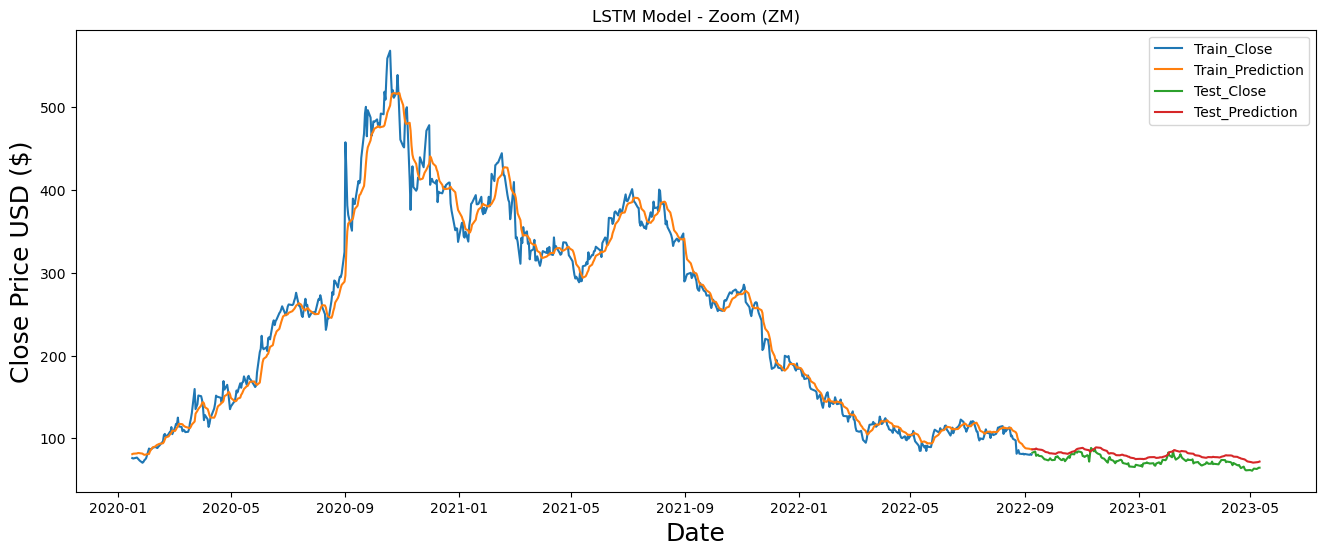

In [119]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('LSTM Model - Zoom (ZM)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_val_zm[['Close', 'Prediction']])
plt.plot(test_zm[['Close', 'Prediction']])
plt.legend(['Train_Close', 'Train_Prediction','Test_Close', 'Test_Prediction'], loc='upper right')
#plt.show()
plt.savefig("images/LSTM Model - Zoom (ZM)")